# Introduction to Generative Adversarial Networks


**Purpose of the notebook**

The following jupyter notebook guides you through the implementation of Deep Convolutional Generative Adversarial Networks with Keras and Tensorflow. The problems addressed are the generation of synthetic handwritten digits (based on the MINST database https://en.wikipedia.org/wiki/MNIST_database) and synthetic images of penguins (inspired by the google "quick, draw!" dataset available at https://quickdraw.withgoogle.com/data).

**Reminder on GANS**

GANs (Generative Adversarial Networks) belong to the family of generative models.

Let's break the acronym down word by word:

1. **Generative**:
GANs learn an input distribution, which can be then sampled and used to generate data and signals. (To grasp the idea look at these amazing results https://www.youtube.com/watch?v=G06dEcZ-QTg&feature=youtu.be).
2. **Adversarial**:
The input distribution is learnt training two different neural nets which compete against each other (but also cooperate): the **generator** and the **discriminator**. 
3. **Networks**:
Because the generator and discriminator are usually implemented by multi-layer networks consisting of convolutional and/or fully-connected layers.

The generator tries to fool the discriminator by generating fake images. The discriminator learns to discriminate real images from fake images. The generator + discriminator form an adversarial network.
GAN trains the discriminator and adversarial networks alternately. During training, not only the discriminator learns to distinguish real from fake images, it also coaches the generator part of the adversarial on how to improve its ability to generate fake images.

**Main references**

1. Goodfellow, I. J., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial networks. arXiv preprint arXiv:1406.2661.

2. Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784.

3. Radford, A., Metz, L. and Chintala, S., 2015. Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.

4. Odena, A., Olah, C., & Shlens, J. (2017, August). Conditional image synthesis with auxiliary classifier gans. In Proceedings of the 34th International Conference on Machine Learning-Volume 70 (pp. 2642-2651). JMLR. org.

5. Creswell, A., White, T., Dumoulin, V., Arulkumaran, K., Sengupta, B., & Bharath, A. A. (2018). Generative adversarial networks: An overview. IEEE Signal Processing Magazine, 35(1), 53-65.

## Preamble

In [1]:
import keras
import numpy as np
import pandas as pd
import scipy as sc
import sklearn as sck
import tensorflow
import random, os, shutil
import PIL
import matplotlib
import matplotlib.pyplot as plt
import re

Using TensorFlow backend.


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('Scipy version', sc.__version__)
print('Scikit-learn version', sck.__version__)
print('Keras version', keras.__version__, 'with Tensorflow', tensorflow.__version__)
print('PIL version', PIL.__version__)
print('Matplotlib version', matplotlib.__version__)

Numpy version 1.15.4
Pandas version 0.23.4
Scipy version 1.1.0
Scikit-learn version 0.20.2
Keras version 2.2.4 with Tensorflow 1.12.0
PIL version 5.1.0
Matplotlib version 3.0.2


# Deep Convolutional GAN

- Radford, A., Metz, L. and Chintala, S., 2015. Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.

Implementation inspired by the work of Erik Linder-Norén on Github: https://github.com/eriklindernoren/Keras-GAN

In [5]:
!rm -rf dcgan_minst_images/
os.makedirs('dcgan_minst_images', exist_ok = True)

In [6]:
class DCGAN():
    """
    A class for Deep Convolutional GAN.
    
    Inspired by Radford, A., Metz, L. and Chintala, S., 2015. 
    Unsupervised representation learning with deep convolutional generative 
    adversarial networks. arXiv preprint arXiv:1511.06434.
    
    """
    
    def __init__(self):

        self.image_rows = 28
        self.image_columns = 28
        self.channels = 1
        self.image_shape = (self.image_rows, self.image_columns, self.channels)
        self.latent_code_dim = 100

        optimizer = keras.optimizers.Adam(0.0002, 0.5)

        # -------------------------------------------------------------------- #
        # Build and compile the Discriminator
        # -------------------------------------------------------------------- #
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss = 'binary_crossentropy', 
                                   optimizer = optimizer, 
                                   metrics = ['accuracy'])
        
        # -------------------------------------------------------------------- #
        # Build the Generator
        # -------------------------------------------------------------------- #
        self.generator = self.build_generator()

        # -------------------------------------------------------------------- #
        # Build the GAN
        # -------------------------------------------------------------------- #
        self.gan = self.build_gan()
        self.gan.compile(loss = 'binary_crossentropy',
                         optimizer = optimizer,
                         metrics = ['accuracy'])

    
    def build_generator(self):
        '''
        Build a generator model for the DCGAN. 
        Keras Functional API adopted.
        
        # Description of input and output layers:
        
        - code (keras.layers.Input()): Input layer which feeds the code vector
        
        - image (keras.layer.Activation()): Output layer which generates the images
        
        The generator is created linking the input and output layers. 
        
        '''
        # -------------------------------------------------------------------- #
        # Inputs
        # -------------------------------------------------------------------- #
        code = keras.layers.Input(shape = (self.latent_code_dim,))
        
        # -------------------------------------------------------------------- #
        # Hidden architecture
        # -------------------------------------------------------------------- #
        x = keras.layers.Dense(units = self.image_rows // 4 * self.image_columns //4 * 128)(code)
        x = keras.layers.Reshape(target_shape = (self.image_rows // 4, self.image_columns //4, 128))(x)
        
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation = 'relu')(x)
        x = keras.layers.Conv2DTranspose(filters = 128, kernel_size = 5, strides = 2, padding = "same")(x)
        
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation = 'relu')(x)
        x = keras.layers.Conv2DTranspose(filters = 64, kernel_size = 5, strides = 2, padding = "same")(x)
        
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation = 'relu')(x)
        x = keras.layers.Conv2DTranspose(filters = 32, kernel_size = 5, strides = 1, padding = "same")(x)
        
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2DTranspose(filters = 1, kernel_size = 5, strides = 1, padding = "same")(x)
        # Output (image generated as output by the generator)
        image = keras.layers.Activation(activation = 'sigmoid')(x)
        
        # Construct the generator and provide a summary.
        generator = keras.models.Model(code, image, name = "GENERATOR")
        generator.summary()
        
        return generator
        
    def test_generator(self, r, c, model_name = "dcgan"):
        
        code = np.random.uniform(-1,1, size = [r * c, 100])
        
        gen_images = self.generator.predict(code)
                
        fig, axs = plt.subplots(r, c, figsize=(10,10))
        num_images = gen_images.shape[0]
        image_size = gen_images.shape[1]
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_images[cnt, :,:,0], cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()    

    def build_discriminator(self):
        '''
        Build a discriminator model for the CGAN. Keras Functional API adopted.
        
        # Description of input and output layers:
        
        '''
        # -------------------------------------------------------------------- #
        # Inputs
        # -------------------------------------------------------------------- #       
        image = keras.layers.Input(shape = self.image_shape)
        
        # -------------------------------------------------------------------- #
        # Hidden architecture
        # -------------------------------------------------------------------- #
        x = keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = "same")(image)
        x = keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = keras.layers.Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = "same")(x)
        x = keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = keras.layers.Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = "same")(x)
        x = keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = keras.layers.Conv2D(filters = 256, kernel_size = 5, strides = 1, padding = "same")(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(units = 1)(x)
        
        # -------------------------------------------------------------------- #        
        # Output (probability that the image is real)
        # -------------------------------------------------------------------- #
        validity = keras.layers.Activation(activation = 'sigmoid')(x)
        
        # -------------------------------------------------------------------- #        
        # Construct the generator and provide a summary. 
        # -------------------------------------------------------------------- #
        discriminator = keras.models.Model(image, validity, name = "DISCRIMINATOR")
        discriminator.summary()
        
        return discriminator
    
    
    def build_gan(self):

        # The generator takes noise as input and generates imgs
        code = keras.layers.Input(shape = (self.latent_code_dim, ))
        image = self.generator(code)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        
        # Please review the folliwing to understand the previous line
        # you can set the trainable property of a layer to True or False after
        # instantiation. For this to take effect, you will need to call
        # compile() on your model after modifying the trainable property.
        # Here's an example:

        # x = Input(shape=(32,))
        # layer = Dense(32)
        # layer.trainable = False
        # y = layer(x)

        # frozen_model = Model(x, y)
        # in the model below, the weights of `layer` will not be updated during training
        # frozen_model.compile(optimizer='rmsprop', loss='mse')

        # layer.trainable = True
        # trainable_model = Model(x, y)
        # with this model the weights of the layer will be updated during training
        # (which will also affect the above model since it uses the same layer instance)
        # trainable_model.compile(optimizer='rmsprop', loss='mse')

        # frozen_model.fit(data, labels)  # this does NOT update the weights of `layer`
        # trainable_model.fit(data, labels)  # this updates the weights of `layer`
        
        
        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(image)

        # -------------------------------------------------------------------- #
        # The combined model (stacked generator and discriminator)
        # -------------------------------------------------------------------- #

        dcgan = keras.models.Model(code, validity)
        dcgan.summary()
        
        return dcgan

    def train(self, epochs = 20, r = 4, c = 4, batch_size = 128, save_interval = 5, model_name = "dcgan"):

        # -------------------------------------------------------------------- #        
        # Load the dataset
        # -------------------------------------------------------------------- #
        (X_train, X_train_labels), (_, _) = keras.datasets.mnist.load_data()

        # -------------------------------------------------------------------- #
        # Rescale 0 to 1
        # -------------------------------------------------------------------- #
        X_train = X_train / 255.
        X_train = np.expand_dims(X_train, axis = 3)

        # -------------------------------------------------------------------- #
        # Adversarial ground truths
        # -------------------------------------------------------------------- #
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # -------------------------------------------------------------------- #
            #  Train Discriminator
            # -------------------------------------------------------------------- #

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            images_real = X_train[idx]
            
            # Sample noise and generate a batch of new images
            code = np.random.uniform(-1, 1, (batch_size, self.latent_code_dim))
            gen_images = self.generator.predict(code)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(images_real, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_images, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # -------------------------------------------------------------------- #
            #  Train Generator
            # -------------------------------------------------------------------- #

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.gan.train_on_batch(code, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, G acc: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], 100*g_loss[1]))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, r, c, model_name = "dcgan")
                
                # save the model after training the generator
                # the trained generator can be reloaded for future MNIST digit generation
        
                self.generator.save("dcgan_minst_images/dcgan_minst_%d_epoch.h5" % epoch)
            
         

    def save_imgs(self, epoch, r, c, model_name = "dcgan"):
        
        os.makedirs('dcgan_minst_images', exist_ok = True)
        
        code = np.random.uniform(-1,1, size = [r * c, 100])
        
        gen_images = self.generator.predict(code)
        
        
        fig, axs = plt.subplots(r, c, figsize=(10,10))
        num_images = gen_images.shape[0]
        image_size = gen_images.shape[1]
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_images[cnt, :,:,0], cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("dcgan_minst_images/mnist_%d.png" % epoch)
        plt.close()    

In [7]:
dcgan_model = DCGAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 128)         0         
__________

In [8]:
dcgan_model.train(epochs = 5000, save_interval = 200)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.737968, acc.: 25.78%] [G loss: 0.684815, G acc: 97.656250]
1 [D loss: 0.678746, acc.: 50.00%] [G loss: 0.768582, G acc: 0.000000]
2 [D loss: 0.622536, acc.: 100.00%] [G loss: 0.879032, G acc: 0.000000]
3 [D loss: 0.570396, acc.: 98.83%] [G loss: 1.030703, G acc: 0.000000]
4 [D loss: 0.488253, acc.: 96.88%] [G loss: 1.236655, G acc: 0.000000]
5 [D loss: 0.386804, acc.: 95.31%] [G loss: 1.446603, G acc: 0.000000]
6 [D loss: 0.297998, acc.: 97.27%] [G loss: 1.473625, G acc: 0.000000]
7 [D loss: 0.186548, acc.: 98.44%] [G loss: 1.276947, G acc: 0.000000]
8 [D loss: 0.087483, acc.: 99.22%] [G loss: 0.435525, G acc: 99.218750]
9 [D loss: 0.049246, acc.: 100.00%] [G loss: 0.045271, G acc: 100.000000]
10 [D loss: 0.021138, acc.: 100.00%] [G loss: 0.013396, G acc: 100.000000]
11 [D loss: 0.012469, acc.: 100.00%] [G loss: 0.008500, G acc: 100.000000]
12 [D loss: 0.009131, acc.: 100.00%] [G loss: 0.006033, G acc: 100.000000]
13 [D loss: 0.008018, acc.: 100.00%] [G loss: 0.004409, G a

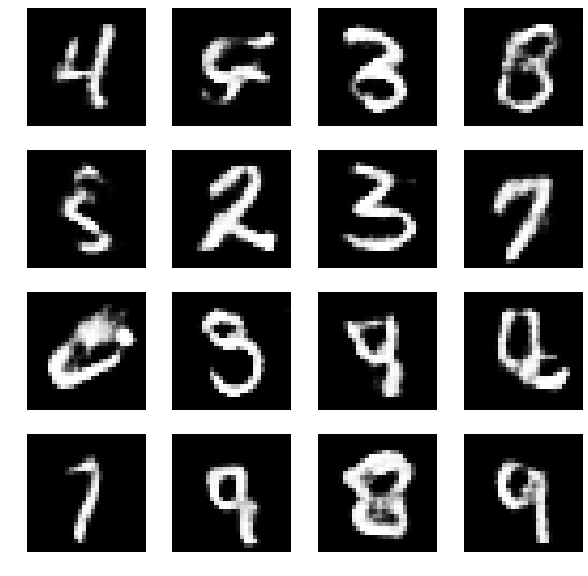

In [9]:
dcgan_model.test_generator(r = 6, c = 6)

# Conditional GAN

A conditional GAN is deeply inherent to the Deep Convolutional Generative Adversial Networks seen before, but adds a condition to the generator and the discriminator in the form of a one-hot vector indicating the class of the MNIST digit image.

- Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784.

Implementation inspired by the work of Erik Linder-Norén on Github: https://github.com/eriklindernoren/Keras-GAN

## Preamble

In [27]:
import keras
import numpy as np
import pandas as pd
import scipy as sc
import sklearn as sck
import tensorflow
import random, os, shutil
import PIL
import matplotlib
import matplotlib.pyplot as plt
import re

In [28]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [29]:
!rm -rf cgan_minst_images/
os.makedirs('cgan_minst_images', exist_ok = True)

## CGAN implementation

In [30]:
class CGAN():
  
    def __init__(self):
      
        self.image_rows = 28
        self.image_columns = 28
        self.channels = 1
        self.image_shape = (self.image_rows, self.image_columns, self.channels)
        self.latent_code_dim = 100
        self.classes_one_hot_dim = 10
        
        optimizer = keras.optimizers.Adam(0.0002, 0.5)
        
        # -------------------------------------------------------------------- #
        # Build and compile the discriminator
        # -------------------------------------------------------------------- #
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss = 'binary_crossentropy', 
                                   optimizer = optimizer, 
                                   metrics = ['accuracy'])
        # -------------------------------------------------------------------- #
        # Build the generator
        # -------------------------------------------------------------------- #
        self.generator = self.build_generator()

        # -------------------------------------------------------------------- #
        # Build the gan
        # -------------------------------------------------------------------- #
        self.gan = self.build_gan()
        self.gan.compile(loss = 'binary_crossentropy',
                         optimizer = optimizer,
                         metrics = ['accuracy'])


    def build_generator(self):
        '''
        Build a generator model for the CGAN. 
        Keras Functional API adopted.
        
        # Description of input and output layers:
        
        - code (keras.layers.Input()): Input layer which feeds the code vector
        - classes (keras.layers.Input()): Input layer which feeds the classes one-hot vector
        
        - image (keras.layer.Activation()): Output layer which generates the images
        
        The generator is created linking the input and output layers. 
        
        '''
        # -------------------------------------------------------------------- #
        # Inputs
        # -------------------------------------------------------------------- #
        code = keras.layers.Input(shape = (self.latent_code_dim,))
        classes = keras.layers.Input(shape = (self.classes_one_hot_dim,))
        # -------------------------------------------------------------------- #
        # Hidden architecture
        # -------------------------------------------------------------------- #
        x = keras.layers.merge.concatenate([code, classes], axis = 1)
        x = keras.layers.Dense(units = self.image_rows // 4 * self.image_columns //4 * 128)(x)
        x = keras.layers.Reshape(target_shape = (self.image_rows // 4, self.image_columns //4, 128))(x)
        
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation = 'relu')(x)
        x = keras.layers.Conv2DTranspose(filters = 128, kernel_size = 5, strides = 2, padding = "same")(x)
        
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation = 'relu')(x)
        x = keras.layers.Conv2DTranspose(filters = 64, kernel_size = 5, strides = 2, padding = "same")(x)
        
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation = 'relu')(x)
        x = keras.layers.Conv2DTranspose(filters = 32, kernel_size = 5, strides = 1, padding = "same")(x)
        
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2DTranspose(filters = 1, kernel_size = 5, strides = 1, padding = "same")(x)
        # Output (image generated as output by the generator)
        image = keras.layers.Activation(activation = 'sigmoid')(x)
        
        # Construct the generator and provide a summary.
        generator = keras.models.Model([code, classes], image, name = "GENERATOR")
        generator.summary()
        
        return generator
    
    
    def test_generator(self, r, c, class_type = None, model_name = "cgan"):
        
        code = np.random.uniform(-1,1, size = [r * c, 100])
        if class_type is None: 
          classes = np.eye(10)[np.random.choice(10, size = r * c)]
        else:
          classes = np.zeros((r * c,10))
          classes[:, class_type] = 1
        
        gen_images = self.generator.predict([code,classes])
        
        print(model_name, " labels for generated images: ", np.argmax(classes, axis=1))
        
        fig, axs = plt.subplots(r, c, figsize=(10,10))
        num_images = gen_images.shape[0]
        image_size = gen_images.shape[1]
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_images[cnt, :,:,0], cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        

    def build_discriminator(self):
        '''
        Build a discriminator model for the CGAN. Keras Functional API adopted.
        
        # Description of input and output layers:
        
        '''
        # -------------------------------------------------------------------- #
        # Inputs
        # -------------------------------------------------------------------- #       
        classes = keras.layers.Input(shape = (self.classes_one_hot_dim, ))
        image = keras.layers.Input(shape = self.image_shape)
        
        # -------------------------------------------------------------------- #
        # Hidden architecture
        # -------------------------------------------------------------------- #
        
        x = keras.layers.Dense(units = self.image_rows //4 * self.image_columns //4 * 16)(classes)
        x = keras.layers.Reshape(target_shape = (self.image_rows, self.image_columns, 1))(x)
        x = keras.layers.merge.concatenate([image,x])
        x = keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = "same")(x)
        x = keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = keras.layers.Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = "same")(x)
        x = keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = keras.layers.Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = "same")(x)
        x = keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = keras.layers.Conv2D(filters = 256, kernel_size = 5, strides = 1, padding = "same")(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(units = 1)(x)
        
        # -------------------------------------------------------------------- #        
        # Output (probability that the image is real)
        # -------------------------------------------------------------------- #
        validity = keras.layers.Activation(activation = 'sigmoid')(x)
        
        # -------------------------------------------------------------------- #        
        # Construct the generator and provide a summary. 
        # -------------------------------------------------------------------- #
        discriminator = keras.models.Model([image, classes], validity, name = "DISCRIMINATOR")
        discriminator.summary()
        
        return discriminator

    def build_gan(self):
        
        # -------------------------------------------------------------------- #
        # The generator takes noise as input and generates images
        # -------------------------------------------------------------------- #
        code = keras.layers.Input(shape = (self.latent_code_dim, ))
        classes = keras.layers.Input(shape = (self.classes_one_hot_dim, ))
        image = self.generator([code, classes])

        # -------------------------------------------------------------------- #
        # For the combined model we will only train the generator
        # -------------------------------------------------------------------- #
        self.discriminator.trainable = False
        
        # Please review the folliwing to understand the previous line
        # you can set the trainable property of a layer to True or False after
        # instantiation. For this to take effect, you will need to call
        # compile() on your model after modifying the trainable property.
        # Here's an example:

        # x = Input(shape=(32,))
        # layer = Dense(32)
        # layer.trainable = False
        # y = layer(x)

        # frozen_model = Model(x, y)
        # in the model below, the weights of `layer` will not be updated during training
        # frozen_model.compile(optimizer='rmsprop', loss='mse')

        # layer.trainable = True
        # trainable_model = Model(x, y)
        # with this model the weights of the layer will be updated during training
        # (which will also affect the above model since it uses the same layer instance)
        # trainable_model.compile(optimizer='rmsprop', loss='mse')

        # frozen_model.fit(data, labels)  # this does NOT update the weights of `layer`
        # trainable_model.fit(data, labels)  # this updates the weights of `layer`
        
        # -------------------------------------------------------------------- #
        # The discriminator takes generated images as input and determines validity
        # -------------------------------------------------------------------- #
        validity = self.discriminator([image, classes])

        # -------------------------------------------------------------------- #
        # The combined model (stacked generator and discriminator)
        # -------------------------------------------------------------------- #

        cgan = keras.models.Model([code,classes], validity)
        cgan.summary()
        
        return cgan
      
      
    def train(self, epochs = 20, r = 4, c = 4, class_type = 0, batch_size = 128, save_interval = 5, model_name = "cgan"):

        # -------------------------------------------------------------------- #        
        # Load the dataset
        # -------------------------------------------------------------------- #
        (X_train, X_train_labels), (_, _) = keras.datasets.mnist.load_data()

        # -------------------------------------------------------------------- #
        # Rescale 0 to 1
        # -------------------------------------------------------------------- #
        X_train = X_train / 255.
        X_train = np.expand_dims(X_train, axis = 3)
        X_train_labels = keras.utils.to_categorical(X_train_labels)

        # -------------------------------------------------------------------- #
        # Adversarial ground truths
        # -------------------------------------------------------------------- #
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # -------------------------------------------------------------------- #
            #  Train Discriminator
            # -------------------------------------------------------------------- #

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            images_real = X_train[idx]
            classes_real = X_train_labels[idx]
            
            # Sample noise and generate a batch of new images
            code = np.random.uniform(-1, 1, (batch_size, self.latent_code_dim))
            classes_fake = np.eye(10)[np.random.choice(10, batch_size)]
            gen_images = self.generator.predict([code,classes_fake])

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch([images_real,classes_real], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_images,classes_fake], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # -------------------------------------------------------------------- #
            #  Train Generator
            # -------------------------------------------------------------------- #

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.gan.train_on_batch([code,classes_fake], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, G acc: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], 100*g_loss[1]))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, r, c, class_type, model_name = "cgan")
                
                # save the model after training the generator
                # the trained generator can be reloaded for future MNIST digit generation
        
                self.generator.save("cgan_minst_images/cgan_minst_%d_epoch.h5" % epoch)
            
         

    def save_imgs(self, epoch, r, c, class_type = None, model_name = "cgan"):
        
        os.makedirs('cgan_minst_images', exist_ok = True)
        
        code = np.random.uniform(-1,1, size = [r * c, 100])
        if class_type is None: 
          classes = np.eye(10)[np.random.choice(10, size = r * c)]
        else:
          classes = np.zeros((r * c,10))
          classes[:, class_type] = 1
        
        gen_images = self.generator.predict([code,classes])
        
        print(model_name, " labels for generated images: ", np.argmax(classes, axis=1))
        
        fig, axs = plt.subplots(r, c, figsize=(10,10))
        num_images = gen_images.shape[0]
        image_size = gen_images.shape[1]
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_images[cnt, :,:,0], cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("cgan_minst_images/mnist_%d.png" % epoch)
        plt.close()

In [31]:
cgan_model = CGAN()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 784)          8624        input_25[0][0]                   
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 28, 28, 1)    0           dense_13[0][0]                   
__________________________________________________________________________________________________
concatenat

In [32]:
cgan_model.train(epochs = 5000, save_interval = 200)

0 [D loss: 0.715972, acc.: 32.42%] [G loss: 0.691506, G acc: 67.187500]
cgan  labels for generated images:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1 [D loss: 0.682897, acc.: 50.00%] [G loss: 0.743849, G acc: 0.000000]
2 [D loss: 0.641722, acc.: 100.00%] [G loss: 0.804338, G acc: 0.000000]
3 [D loss: 0.609424, acc.: 98.83%] [G loss: 0.854478, G acc: 0.000000]
4 [D loss: 0.571877, acc.: 95.70%] [G loss: 0.979968, G acc: 0.000000]
5 [D loss: 0.506735, acc.: 96.88%] [G loss: 1.118960, G acc: 0.000000]
6 [D loss: 0.380966, acc.: 96.88%] [G loss: 1.245137, G acc: 0.000000]
7 [D loss: 0.259974, acc.: 95.70%] [G loss: 1.114101, G acc: 0.000000]
8 [D loss: 0.147493, acc.: 96.88%] [G loss: 0.381085, G acc: 98.437500]
9 [D loss: 0.067309, acc.: 99.61%] [G loss: 0.023484, G acc: 100.000000]
10 [D loss: 0.033981, acc.: 100.00%] [G loss: 0.003939, G acc: 100.000000]
11 [D loss: 0.018202, acc.: 100.00%] [G loss: 0.001823, G acc: 100.000000]
12 [D loss: 0.014778, acc.: 100.00%] [G loss: 0.001251, G acc: 10

cgan  labels for generated images:  [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


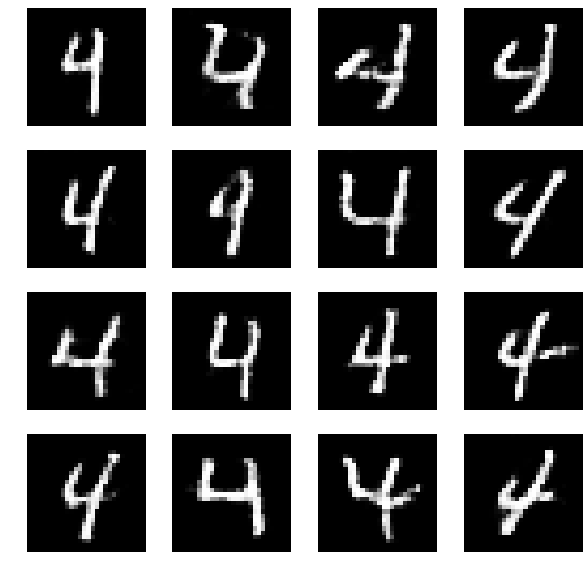

In [34]:
cgan_model.test_generator(r = 4, c = 4, class_type = 4)

# Penguins

In [20]:
penguins = np.load('full-numpy_bitmap-penguin.npy')

In [21]:
penguins.shape

(253791, 784)

In [22]:
penguins = np.reshape(penguins, newshape=(penguins.shape[0],28,28))/255

In [23]:
penguins.shape

(253791, 28, 28)

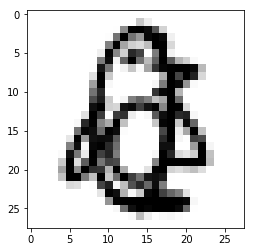

In [25]:
plt.imshow(penguins[10,:,:], cmap='Greys')

In [47]:
!rm -rf dcgan_penguins_images/
os.makedirs('dcgan_penguins_images', exist_ok = True)

In [44]:
class DCGAN_penguins():
    """
    A class for Deep Convolutional GAN.
    
    Inspired by Radford, A., Metz, L. and Chintala, S., 2015. 
    Unsupervised representation learning with deep convolutional generative 
    adversarial networks. arXiv preprint arXiv:1511.06434.
    
    """
    
    def __init__(self):

        self.image_rows = 28
        self.image_columns = 28
        self.channels = 1
        self.image_shape = (self.image_rows, self.image_columns, self.channels)
        self.latent_code_dim = 100

        optimizer = keras.optimizers.Adam(0.0002, 0.5)

        # -------------------------------------------------------------------- #
        # Build and compile the Discriminator
        # -------------------------------------------------------------------- #
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss = 'binary_crossentropy', 
                                   optimizer = optimizer, 
                                   metrics = ['accuracy'])
        
        # -------------------------------------------------------------------- #
        # Build the Generator
        # -------------------------------------------------------------------- #
        self.generator = self.build_generator()

        # -------------------------------------------------------------------- #
        # Build the GAN
        # -------------------------------------------------------------------- #
        self.gan = self.build_gan()
        self.gan.compile(loss = 'binary_crossentropy',
                         optimizer = optimizer,
                         metrics = ['accuracy'])

    
    def build_generator(self):
        '''
        Build a generator model for the DCGAN. 
        Keras Functional API adopted.
        
        # Description of input and output layers:
        
        - code (keras.layers.Input()): Input layer which feeds the code vector
        
        - image (keras.layer.Activation()): Output layer which generates the images
        
        The generator is created linking the input and output layers. 
        
        '''
        # -------------------------------------------------------------------- #
        # Inputs
        # -------------------------------------------------------------------- #
        code = keras.layers.Input(shape = (self.latent_code_dim,))
        
        # -------------------------------------------------------------------- #
        # Hidden architecture
        # -------------------------------------------------------------------- #
        x = keras.layers.Dense(units = self.image_rows // 4 * self.image_columns //4 * 128)(code)
        x = keras.layers.Reshape(target_shape = (self.image_rows // 4, self.image_columns //4, 128))(x)
        
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation = 'relu')(x)
        x = keras.layers.Conv2DTranspose(filters = 128, kernel_size = 5, strides = 2, padding = "same")(x)
        
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation = 'relu')(x)
        x = keras.layers.Conv2DTranspose(filters = 64, kernel_size = 5, strides = 2, padding = "same")(x)
        
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation = 'relu')(x)
        x = keras.layers.Conv2DTranspose(filters = 32, kernel_size = 5, strides = 1, padding = "same")(x)
        
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2DTranspose(filters = 1, kernel_size = 5, strides = 1, padding = "same")(x)
        # Output (image generated as output by the generator)
        image = keras.layers.Activation(activation = 'sigmoid')(x)
        
        # Construct the generator and provide a summary.
        generator = keras.models.Model(code, image, name = "GENERATOR")
        generator.summary()
        
        return generator
        
    def test_generator(self, r, c, model_name = "dcgan"):
        
        code = np.random.uniform(-1,1, size = [r * c, 100])
        
        gen_images = self.generator.predict(code)
                
        fig, axs = plt.subplots(r, c, figsize=(10,10))
        num_images = gen_images.shape[0]
        image_size = gen_images.shape[1]
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_images[cnt, :,:,0], cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()    

    def build_discriminator(self):
        '''
        Build a discriminator model for the CGAN. Keras Functional API adopted.
        
        # Description of input and output layers:
        
        '''
        # -------------------------------------------------------------------- #
        # Inputs
        # -------------------------------------------------------------------- #       
        image = keras.layers.Input(shape = self.image_shape)
        
        # -------------------------------------------------------------------- #
        # Hidden architecture
        # -------------------------------------------------------------------- #
        x = keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = "same")(image)
        x = keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = keras.layers.Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = "same")(x)
        x = keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = keras.layers.Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = "same")(x)
        x = keras.layers.LeakyReLU(alpha = 0.2)(x)
        x = keras.layers.Conv2D(filters = 256, kernel_size = 5, strides = 1, padding = "same")(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(units = 1)(x)
        
        # -------------------------------------------------------------------- #        
        # Output (probability that the image is real)
        # -------------------------------------------------------------------- #
        validity = keras.layers.Activation(activation = 'sigmoid')(x)
        
        # -------------------------------------------------------------------- #        
        # Construct the generator and provide a summary. 
        # -------------------------------------------------------------------- #
        discriminator = keras.models.Model(image, validity, name = "DISCRIMINATOR")
        discriminator.summary()
        
        return discriminator
    
    
    def build_gan(self):

        # The generator takes noise as input and generates imgs
        code = keras.layers.Input(shape = (self.latent_code_dim, ))
        image = self.generator(code)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        
        # Please review the folliwing to understand the previous line
        # you can set the trainable property of a layer to True or False after
        # instantiation. For this to take effect, you will need to call
        # compile() on your model after modifying the trainable property.
        # Here's an example:

        # x = Input(shape=(32,))
        # layer = Dense(32)
        # layer.trainable = False
        # y = layer(x)

        # frozen_model = Model(x, y)
        # in the model below, the weights of `layer` will not be updated during training
        # frozen_model.compile(optimizer='rmsprop', loss='mse')

        # layer.trainable = True
        # trainable_model = Model(x, y)
        # with this model the weights of the layer will be updated during training
        # (which will also affect the above model since it uses the same layer instance)
        # trainable_model.compile(optimizer='rmsprop', loss='mse')

        # frozen_model.fit(data, labels)  # this does NOT update the weights of `layer`
        # trainable_model.fit(data, labels)  # this updates the weights of `layer`
        
        
        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(image)

        # -------------------------------------------------------------------- #
        # The combined model (stacked generator and discriminator)
        # -------------------------------------------------------------------- #

        dcgan = keras.models.Model(code, validity)
        dcgan.summary()
        
        return dcgan

    def train(self, epochs = 20, r = 4, c = 4, batch_size = 128, save_interval = 5, model_name = "dcgan"):

        # -------------------------------------------------------------------- #        
        # Load the dataset
        # -------------------------------------------------------------------- #
        X_train = np.load('full-numpy_bitmap-penguin.npy')
        X_train = np.reshape(X_train, newshape=(penguins.shape[0],28,28))
        # -------------------------------------------------------------------- #
        # Rescale 0 to 1
        # -------------------------------------------------------------------- #
        X_train = X_train[:10000,:,:] / 255.
        X_train = np.expand_dims(X_train, axis = 3)

        # -------------------------------------------------------------------- #
        # Adversarial ground truths
        # -------------------------------------------------------------------- #
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # -------------------------------------------------------------------- #
            #  Train Discriminator
            # -------------------------------------------------------------------- #

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            images_real = X_train[idx]
            
            # Sample noise and generate a batch of new images
            code = np.random.uniform(-1, 1, (batch_size, self.latent_code_dim))
            gen_images = self.generator.predict(code)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(images_real, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_images, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # -------------------------------------------------------------------- #
            #  Train Generator
            # -------------------------------------------------------------------- #

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.gan.train_on_batch(code, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, G acc: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], 100*g_loss[1]))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, r, c, model_name = "dcgan")
                
                # save the model after training the generator
                # the trained generator can be reloaded for future MNIST digit generation
        
                self.generator.save("dcgan_penguins_images/dcgan_penguins_%d_epoch.h5" % epoch)
            
         

    def save_imgs(self, epoch, r, c, model_name = "dcgan"):
        
        os.makedirs('dcgan_penguins_images', exist_ok = True)
        
        code = np.random.uniform(-1,1, size = [r * c, 100])
        
        gen_images = self.generator.predict(code)
        
        
        fig, axs = plt.subplots(r, c, figsize=(10,10))
        num_images = gen_images.shape[0]
        image_size = gen_images.shape[1]
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_images[cnt, :,:,0], cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("dcgan_penguins_images/penguins_%d.png" % epoch)
        plt.close()    

In [45]:
dcgan_model_penguins = DCGAN_penguins()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 4, 4, 128)         0         
__________

In [48]:
dcgan_model_penguins.train(epochs = 1000, save_interval = 50)

0 [D loss: 0.693630, acc.: 50.00%] [G loss: 0.751091, G acc: 27.343750]
1 [D loss: 0.683024, acc.: 54.69%] [G loss: 0.794415, G acc: 16.406250]
2 [D loss: 0.678798, acc.: 56.25%] [G loss: 0.809107, G acc: 10.156250]
3 [D loss: 0.689264, acc.: 52.34%] [G loss: 0.801959, G acc: 16.406250]
4 [D loss: 0.703622, acc.: 46.48%] [G loss: 0.797458, G acc: 15.625000]
5 [D loss: 0.686089, acc.: 54.69%] [G loss: 0.805578, G acc: 14.843750]
6 [D loss: 0.685884, acc.: 54.69%] [G loss: 0.798858, G acc: 22.656250]
7 [D loss: 0.663105, acc.: 64.45%] [G loss: 0.794213, G acc: 17.187500]
8 [D loss: 0.686223, acc.: 54.30%] [G loss: 0.775959, G acc: 19.531250]
9 [D loss: 0.688530, acc.: 50.39%] [G loss: 0.790678, G acc: 17.187500]
10 [D loss: 0.686856, acc.: 53.52%] [G loss: 0.783973, G acc: 19.531250]
11 [D loss: 0.675930, acc.: 58.59%] [G loss: 0.816605, G acc: 10.156250]
12 [D loss: 0.675782, acc.: 60.55%] [G loss: 0.803559, G acc: 13.281250]
13 [D loss: 0.671375, acc.: 61.72%] [G loss: 0.821962, G acc:

In [1]:
dcgan_model_penguins.test_generator(r = 6, c = 6)

NameError: name 'dcgan_model_penguins' is not defined